

## Journal used for the implemetation
Journal title: **Using DUCK-Net for Polyp Image Segmentation**

Authors: Razvan-Gabriel Dumitru, Darius Peteleaza, Catalin Craciun

Journal Name: Nature

Year: 16 June 2023

link: https://www.nature.com/articles/s41598-023-36940-5ear:

In [1]:
# Install requirements
!pip install numpy==1.23.1 tensorflow==2.10.0 scikit-learn==1.1.1 opencv-python==4.6.0.66 matplotlib==3.5.2 tqdm==4.64.0
!pip install Pillow==9.2.0 scikit-image==0.19.3 keras==2.10.0

  Using cached numpy-1.23.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached tensorflow-2.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)
  Using cached scikit_learn-1.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.8 MB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
  Using cached matplotlib-3.5.2-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
     |████████████████████████████████| 4.5 MB 1.6 MB/s eta 0:00:01
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.2.1 requires scikit-image>=0.16.1, which is not installed.
datasets 1.8.0 requires huggingface-hub<0.1.0, but you have huggingfac

# 1. Import the required libraries

In [2]:
import tensorflow as tf
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

import glob
from PIL import Image
from skimage.io import imread
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, add, Conv2D, UpSampling2D

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

2024-02-26 12:44:19.699692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 12:44:19.900060: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 12:44:20.740705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-26 12:44:20.740814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# 2. Data Acquisition

URL of the data used: https://datasets.simula.no/kvasir-seg/

In [3]:
# Download dataset for training 
!wget https://datasets.simula.no/downloads/kvasir-seg.zip
!unzip kvasir-seg.zip

--2024-02-26 11:54:19--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip’

kvasir-seg.zip      100%[===================>]  44.08M  16.6MB/s    in 2.7s    

2024-02-26 11:54:23 (16.6 MB/s) - ‘kvasir-seg.zip’ saved [46227172/46227172]

Archive:  kvasir-seg.zip
   creating: Kvasir-SEG/
  inflating: Kvasir-SEG/kavsir_bboxes.json  
   creating: Kvasir-SEG/images/
  inflating: Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
  inflating: Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg  
  inflating: Kvasir-SEG/images/ck2bxlujamu330725szlc2jdu.jpg  
  inflating: Kvasir-SEG/images/ck2bxpfgxu2mk0748gsh7xelu.jpg  
  inflating: Kvasir-SEG/images/ck2bxqz3evvg20794iiyv5v2m.jpg  
  inflating: Kvasir-SEG/images/ck2bxskgxxzfv08386xkqt

### Model Training Configuration:

In [3]:

data_path = "./Kvasir-SEG"  # Add path to your data directory

img_size = 352   # Image size as defined in paper

# Model Config
EPOCHS = 50
learning_rate = 1e-4       
seed_value = 580
filters = 17 # Number of filters, the paper presents the results with 17 and 34

# Batch size for augmentation using tensorflow-keras
batch_size = 32

# Training Params
model_path = './'  # saved model path i.e. root of working directory
# Use an appropriate batch size for your GPU
BATCH_SIZE = 2  # Example batch size, adjust as needed

csv_logger_path = './output_logger.csv'

In [4]:
# Data Generation
# processing the raw data for training format 
# code is written to process data in parallel for fast execution

def process_image(image_path, img_height, img_width):
    mask_path = image_path.replace("images", "masks")

    image = imread(image_path)
    mask_ = imread(mask_path, as_gray=True)

    pillow_image = Image.fromarray(image)
    pillow_image = pillow_image.resize((img_height, img_width))
    image = np.array(pillow_image) / 255

    pillow_mask = Image.fromarray(mask_)
    pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
    mask_ = np.array(pillow_mask)

    mask = (mask_ >= 127).astype(np.uint8)

    return image, mask[..., np.newaxis]

def load_data(data_path, img_height, img_width):
    IMAGES_PATH = data_path + '/images/'
    MASKS_PATH = data_path + '/masks/'

    image_paths = glob.glob(IMAGES_PATH + "*.jpg")
    images_to_be_loaded = len(image_paths)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width, 1), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, image_path, img_height, img_width) for image_path in image_paths]
        for i, future in tqdm(enumerate(as_completed(futures)), total=len(futures)):
            image, mask = future.result()
            X_train[i] = image
            Y_train[i] = mask

    return X_train, Y_train

X, Y = load_data(data_path, img_size, img_size)

Resizing training images and masks: 1000


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_32230/3277777811.py:16: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
100%|██████████| 1000/1000 [00:07<00:00, 136.57it/s]


# 3. Data Preparation

This step preparse the training data using augmentation based on tensorflow-keras to create unique data points which covers all other cases which is not defined by raw dataset

In [5]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, shuffle= True, random_state = seed_value)


# Define the augmentations using Keras ImageDataGenerator
aug_train = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.6, 1.6),
    rotation_range=180,
    shear_range=22.5,
    zoom_range=[0.5, 1.5],
    fill_mode='reflect'  # You can also use nearest, constant, or wrap
)

def augment_images_keras(x_train, y_train, batch_size):
    
    # Initialize the image data generator with the input data
    seed = 1  # Ensuring the same seed for image and mask generators
    image_gen = aug_train.flow(x_train, batch_size=batch_size, seed=seed)
    mask_gen = aug_train.flow(y_train, batch_size=batch_size, seed=seed)

    # Combine the generators
    def combine_generators(gen1, gen2):
        while True:
            yield(next(gen1), next(gen2))

    combined_gen = combine_generators(image_gen, mask_gen)

    # Generate augmented images and masks
    x_train_out = []
    y_train_out = []
    num_augmented = 0
    for x_batch, y_batch in combined_gen:
        x_train_out.append(x_batch)
        y_train_out.append(y_batch)
        num_augmented += batch_size
        if num_augmented >= len(x_train):
            break

    # Concatenate the results
    x_train_out = np.concatenate(x_train_out, axis=0)[:len(x_train)]
    y_train_out = np.concatenate(y_train_out, axis=0)[:len(y_train)]

    return x_train_out, y_train_out

x_train_augmented, y_train_augmented = augment_images_keras(x_train, y_train, batch_size)

In [6]:
# Input data variable looks like
x_train_augmented

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [7]:
# Target data Variable looks like
y_train_augmented

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced



In [8]:
# Custom Model architecture Duck-Net

kernel_initializer = 'he_uniform'
interpolation = "nearest"

def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalization(axis=-1)(x)
    x1 = widescope_conv2D_block(x, filters)

    x2 = midscope_conv2D_block(x, filters)

    x3 = resnet_conv2D_block(x, filters, dilation_rate=1)

    x4 = resnet_conv2D_block(x, filters, dilation_rate=1)
    x4 = resnet_conv2D_block(x4, filters, dilation_rate=1)

    x5 = resnet_conv2D_block(x, filters, dilation_rate=1)
    x5 = resnet_conv2D_block(x5, filters, dilation_rate=1)
    x5 = resnet_conv2D_block(x5, filters, dilation_rate=1)

    x6 = separated_conv2D_block(x, filters, size=6, padding='same')

    x = add([x1, x2, x3, x4, x5, x6])

    x = BatchNormalization(axis=-1)(x)

    return x


def separated_conv2D_block(x, filters, size=3, padding='same'):
    x = Conv2D(filters, (1, size), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (size, 1), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)
    x = BatchNormalization(axis=-1)(x)

    return x


def midscope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)
    x = BatchNormalization(axis=-1)(x)

    return x


def widescope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=3)(x)
    x = BatchNormalization(axis=-1)(x)

    return x


def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same',
                dilation_rate=dilation_rate)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x_final = add([x, x1])
    x_final = BatchNormalization(axis=-1)(x_final)

    return x_final

def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

def create_model(img_height, img_width, input_chanels, out_classes, starting_filters):
    input_layer = tf.keras.layers.Input((img_height, img_width, input_chanels))

    print('DUCK-Net Model Loaded successfully')

    p1 = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(input_layer)
    p2 = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(p1)
    p3 = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(p2)
    p4 = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(p3)
    p5 = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(p4)

    t0 = duckv2_conv2D_block(input_layer, starting_filters, size=3)

    l1i = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(t0)
    s1 = add([l1i, p1])
    t1 = duckv2_conv2D_block(s1, starting_filters * 2, size=3)

    l2i = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(t1)
    s2 = add([l2i, p2])
    t2 = duckv2_conv2D_block(s2, starting_filters * 4, size=3)

    l3i = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(t2)
    s3 = add([l3i, p3])
    t3 = duckv2_conv2D_block(s3, starting_filters * 8, size=3)

    l4i = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(t3)
    s4 = add([l4i, p4])
    t4 = duckv2_conv2D_block(s4, starting_filters * 16, size=3)

    l5i = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(t4)
    s5 = add([l5i, p5])
    t51 = resnet_conv2D_block(s5, starting_filters * 32, dilation_rate=1)
    t52 = resnet_conv2D_block(t51, starting_filters * 32, dilation_rate=1)
    t53 = resnet_conv2D_block(t52, starting_filters * 16, dilation_rate=1)
    t54 = resnet_conv2D_block(t53, starting_filters * 16, dilation_rate=1)

    l5o = UpSampling2D((2, 2), interpolation=interpolation)(t54)
    c4 = add([l5o, t4])
    q4 = duckv2_conv2D_block(c4, starting_filters * 8, size=3)

    l4o = UpSampling2D((2, 2), interpolation=interpolation)(q4)
    c3 = add([l4o, t3])
    q3 = duckv2_conv2D_block(c3, starting_filters * 4, size=3)

    l3o = UpSampling2D((2, 2), interpolation=interpolation)(q3)
    c2 = add([l3o, t2])
    q6 = duckv2_conv2D_block(c2, starting_filters * 2, size=3)

    l2o = UpSampling2D((2, 2), interpolation=interpolation)(q6)
    c1 = add([l2o, t1])
    q1 = duckv2_conv2D_block(c1, starting_filters, size=3)

    l1o = UpSampling2D((2, 2), interpolation=interpolation)(q1)
    c0 = add([l1o, t0])
    z1 = duckv2_conv2D_block(c0, starting_filters, size=3)

    output = Conv2D(out_classes, (1, 1), activation='sigmoid')(z1)

    model = Model(inputs=input_layer, outputs=output)

    return model


In [9]:
# Creating the model

model = create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)


DUCK-Net Model Loaded successfully


2024-02-26 12:45:17.506037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-26 12:45:17.509449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-26 12:45:17.543243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-26 12:45:17.546203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-26 12:45:17.549131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters



## DuckNet Architecture:
![Image](DUCK-Net.png)

## DuckNet Block:
![Image](DUCK-Block.png) 

In [10]:
# Summary of layers
print('Summary of Duck-Net Model')
model.summary()

Summary of Duck-Net Model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 352, 352, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 352, 352, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d_20 (Conv2D)             (None, 352, 352, 17  476         ['batch_normalization[0][0]']    
                                )                                   

DUCK-NET Model:
* Total params: 38,921,088
* Trainable params: 38,867,668
* Non-trainable params: 53,420

# 5. Training the model


In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [12]:
# Configure the training, by using appropriate optimizers, regularizations and loss functions

# Dice_metric_loss function
def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = tf.cast(ground_truth, tf.float32)
    predictions = tf.cast(predictions, tf.float32)
    intersection = K.sum(predictions * ground_truth)
    union = K.sum(predictions) + K.sum(ground_truth)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# Optmizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

# Compiling the model
model.compile(optimizer=optimizer, loss=dice_metric_loss, metrics=['accuracy'])

# Set up callbacks
csv_logger = CSVLogger(csv_logger_path, append=True, separator=';')

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)

# Initialize lists to store history
loss_train_history = []
loss_val_history = []
f1_train_history = []
f1_val_history = []

# Training loop
for epoch in range(EPOCHS):
    print(f'Training, epoch {epoch}')

    # Train the model
    history = model.fit(
        x=x_train_augmented,
        y=y_train_augmented,
        epochs=1,
        batch_size=BATCH_SIZE,
        validation_data=(x_valid, y_valid),
        verbose=1,
        callbacks=[csv_logger, checkpoint]
    )

    # Save the losses
    loss_train_history.append(history.history['loss'][0])
    loss_val_history.append(history.history['val_loss'][0])

    # Predictions for F1 score calculations
    prediction_train = model.predict(x_train_augmented, verbose=0)
    prediction_valid = model.predict(x_valid, verbose=0)

    # Flatten the predictions and truth arrays for F1 score calculation
    y_true_train = np.ndarray.flatten(np.array(y_train_augmented, dtype=bool))
    y_pred_train = np.ndarray.flatten(prediction_train > 0.5)  # Assuming a threshold of 0.5
    y_true_val = np.ndarray.flatten(np.array(y_valid, dtype=bool))
    y_pred_val = np.ndarray.flatten(prediction_valid > 0.5)  # Assuming a threshold of 0.5

    # Calculate F1 scores and append to history
    f1_train = f1_score(y_true_train, y_pred_train)
    f1_val = f1_score(y_true_val, y_pred_val)
    f1_train_history.append(f1_train)
    f1_val_history.append(f1_val)

    print("F1 Training: " + str(f1_train))
    print("F1 Validation: " + str(f1_val))

# Optionally, clear memory after training
if 'gc' in locals():
    gc.collect()


Training, epoch 0


2024-02-26 12:49:06.322555: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900
2024-02-26 12:49:07.039003: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


340/340 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.4329

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


340/340 [==============================] - 337s 790ms/step - loss: 1.0000 - accuracy: 0.4329 - val_loss: 1.0000 - val_accuracy: 0.7301
F1 Training: 0.0
F1 Validation: 0.0
Training, epoch 1
340/340 [==============================] - 179s 525ms/step - loss: 1.0000 - accuracy: 0.4310 - val_loss: 1.0000 - val_accuracy: 0.9980
F1 Training: 0.0
F1 Validation: 0.0
Training, epoch 2
340/340 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.4313

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


340/340 [==============================] - 261s 768ms/step - loss: 1.0000 - accuracy: 0.4313 - val_loss: 1.0000 - val_accuracy: 0.9996
F1 Training: 0.0
F1 Validation: 0.0
Training, epoch 3
340/340 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.4315

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


340/340 [==============================] - 262s 770ms/step - loss: 1.0000 - accuracy: 0.4315 - val_loss: 1.0000 - val_accuracy: 0.9998
F1 Training: 0.0
F1 Validation: 0.0
Training, epoch 4
340/340 [==============================] - 178s 525ms/step - loss: 1.0000 - accuracy: 0.4308 - val_loss: 1.0000 - val_accuracy: 0.9998
F1 Training: 0.0
F1 Validation: 0.0
Training, epoch 5
340/340 [==============================] - 178s 524ms/step - loss: 1.0000 - accuracy: 0.4307 - val_loss: 1.0000 - val_accuracy: 0.9997
F1 Training: 0.0
F1 Validation: 0.0
Training, epoch 6
340/340 [==============================] - 178s 524ms/step - loss: 1.0000 - accuracy: 0.4318 - val_loss: 1.0000 - val_accuracy: 0.9991
F1 Training: 0.0
F1 Validation: 0.0
Training, epoch 7
340/340 [==============================] - 178s 524ms/step - loss: 1.0000 - accuracy: 0.4324 - val_loss: 1.0000 - val_accuracy: 0.9995


2024-02-26 13:27:19.169391: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 263.00MiB (rounded to 275777536)requested by op model/conv2d_9/Conv2D/SpaceToBatchND
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-26 13:27:19.169876: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2024-02-26 13:27:19.169915: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 1178, Chunks in use: 1144. 294.5KiB allocated for chunks. 286.0KiB in use in bin. 100.0KiB client-requested in use in bin.
2024-02-26 13:27:19.169934: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 842, Chunks in use: 725. 515.2KiB allocated for chunks. 447.2KiB in use in bin. 271.5KiB client-requested in

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_9/Conv2D/SpaceToBatchND' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.9/dist-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.9/dist-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.9/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32230/3505878939.py", line 49, in <module>
      prediction_train = model.predict(x_train_augmented, verbose=0)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.9/dist-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.9/dist-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv2d_9/Conv2D/SpaceToBatchND'
OOM when allocating tensor with shape[128,178,178,17] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_9/Conv2D/SpaceToBatchND}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_235219]

# 6. Test the model


In [13]:
# Evaluation
model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_test = model.predict(x_test, batch_size=4)

f1_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
print("F1 Testing: " + str(f1_test))

50/50 [==============================] - 20s 249ms/step
F1 Testing: 0.0


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


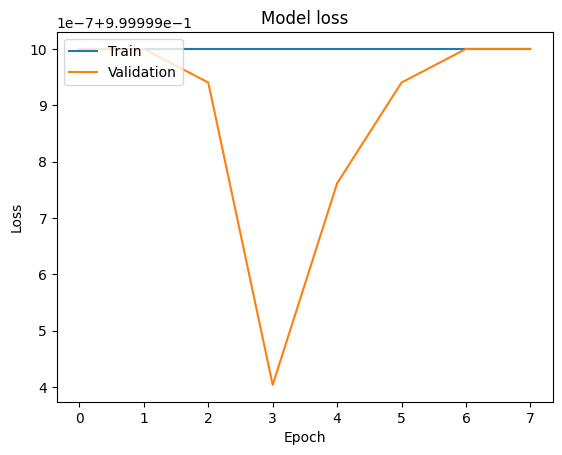

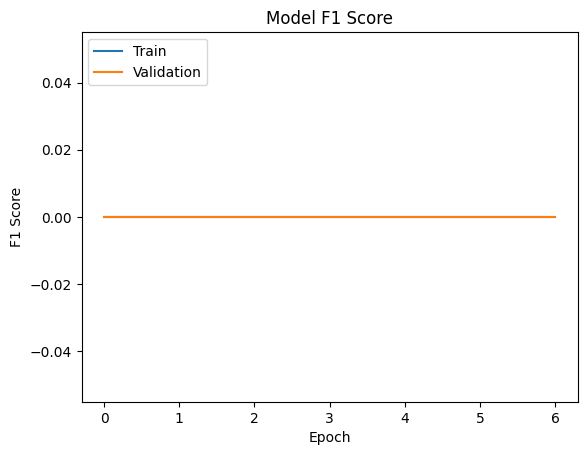

Testing Loss:  1.0
Testing Accuracy:  0.9999209642410278


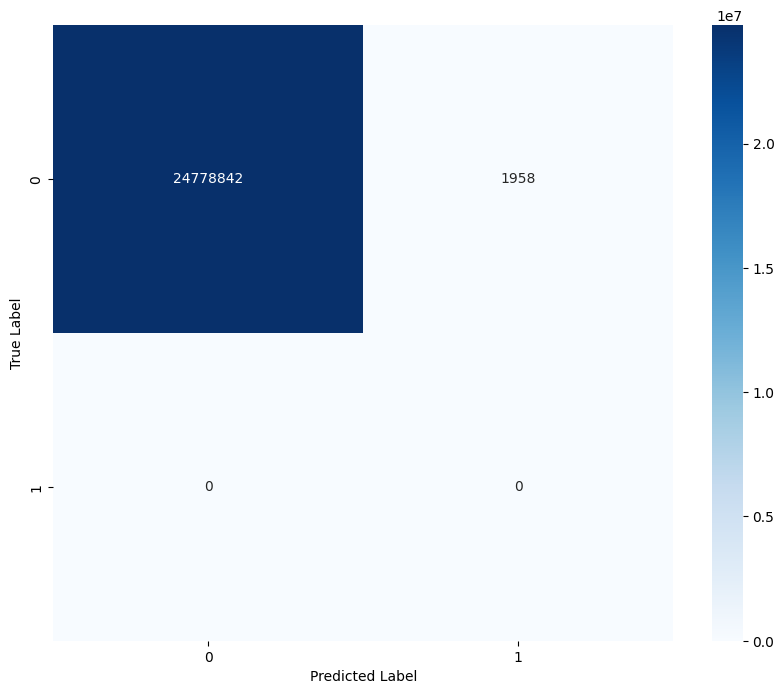

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.999920987215909
Precision:  0.0
Recall:  0.0
F1 Score:  0.0


In [14]:

# Plot training & validation loss values
plt.plot(loss_train_history)
plt.plot(loss_val_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation F1 score values
plt.plot(f1_train_history)
plt.plot(f1_val_history)
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data
loss_test, accuracy_test = model.evaluate(x_test, y_test, verbose=0)
prediction_test = model.predict(x_test, verbose=0)

print("Testing Loss: ", loss_test)
print("Testing Accuracy: ", accuracy_test)

# Compute confusion matrix and other performance metrics for the test data
y_true_test = np.ndarray.flatten(np.array(y_test, dtype=bool))
y_pred_test = np.ndarray.flatten(prediction_test > 0.5)  # Assuming a threshold of 0.5

cm = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Report performance metrics
accuracy = accuracy_score(y_true_test, y_pred_test)
precision = precision_score(y_true_test, y_pred_test)
recall = recall_score(y_true_test, y_pred_test)
f1 = f1_score(y_true_test, y_pred_test)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
